Document Purpose: Intake CSV file dump of all ozone readings for the state of CA. Split into county specific DFs, identify the worst offending counties, difference all TS data, find rolling yearly averages per county, pickle and export results for all counties to use as target variable for TRI data regressions. 

In [185]:
import pandas as pd
import numpy as np
import requests
# from scrapy.selector import Selector
# from scrapy.http import HtmlResponse
import json
import csv
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pickle
import json
import folium
import vincent


import seaborn as sb

%matplotlib inline


In [186]:
oz_df = pd.read_csv('daily_44201_2015.csv')
oz_df2 = pd.read_csv('daily_44201_2014.csv')
oz_df3 = pd.read_csv('daily_44201_2013.csv')

# CA_df = oz_df[oz_df['State Code'] == 06]
# CA_df[CA_df['AQI']>100]


In [187]:
CA_OZ1 = oz_df[ (oz_df['State Code'] == 06)]['County Name'].unique()
CA_OZ2 = oz_df2[(oz_df2['State Code'] == 06)]['County Name'].unique()
CA_OZ3 = oz_df3[(oz_df3['State Code'] == 06)]['County Name'].unique()

CA_all = list(CA_OZ1) + list(CA_OZ2) + list(CA_OZ3)
CA_County_full = list(set(CA_all))
len(CA_County_full)


49

In [188]:
## returns list of counties in that sate with values above your threshold

def get_worst_offenders_cnty(threshold, state_num):
    CA_OZ1 = oz_df[(oz_df['AQI']>threshold) & (oz_df['State Code'] == state_num)]['County Name'].unique()
    CA_OZ2 = oz_df2[(oz_df2['AQI']>threshold) & (oz_df2['State Code'] == state_num)]['County Name'].unique()
    CA_OZ3 = oz_df3[(oz_df3['AQI']>threshold) & (oz_df3['State Code'] == state_num)]['County Name'].unique()
    
    CA_all = list(CA_OZ1) + list(CA_OZ2) + list(CA_OZ3)
    CA_Counties = list(set(CA_all))
    return CA_Counties

In [189]:
CA_Counties = get_worst_offenders_cnty(200, 06)

In [272]:
def make_geoid(aa):
    if len(aa) == 1:
        return  "05000US0600" + str(aa)
    elif len(aa)== 2:
        return  "05000US060" + str(aa)
    else:
        return  "05000US060" + str(aa)

In [274]:
geoid_df = CA_df_14[['State Code','County Code', 'County Name'  ]]

geoid_df['geoid'] = geoid_df['County Code'].astype(str).apply(make_geoid)
geoid_df

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,State Code,County Code,County Name,geoid
25061,6,1,Alameda,05000US06001
25062,6,1,Alameda,05000US06001
25063,6,1,Alameda,05000US06001
25064,6,1,Alameda,05000US06001
25065,6,1,Alameda,05000US06001
25066,6,1,Alameda,05000US06001
25067,6,1,Alameda,05000US06001
25068,6,1,Alameda,05000US06001
25069,6,1,Alameda,05000US06001
25070,6,1,Alameda,05000US06001


In [190]:
##make mega DF

CA_df_15 = oz_df[oz_df['State Code'] == 06]
CA_df_14 = oz_df2[oz_df2['State Code'] == 06]
CA_df_13 = oz_df3[oz_df3['State Code'] == 06]
CA_3y_df = pd.concat([CA_df_13, CA_df_14, CA_df_15], ignore_index=True)
CA_3y_df = CA_3y_df.set_index(pd.to_datetime(CA_3y_df['Date Local']))


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
Date Local,,,,,,,,,,,,,,,,,,,,,
2013-01-01,6,1,7,44201,1,37.687526,-121.784217,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,26,NaN,-,Livermore,793 Rincon Ave.,California,Alameda,Livermore,"San Francisco-Oakland-Hayward, CA",2016-06-18
2013-01-02,6,1,7,44201,1,37.687526,-121.784217,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,21,NaN,-,Livermore,793 Rincon Ave.,California,Alameda,Livermore,"San Francisco-Oakland-Hayward, CA",2016-06-18


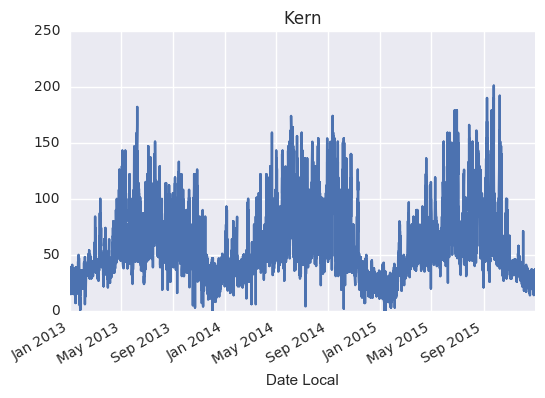

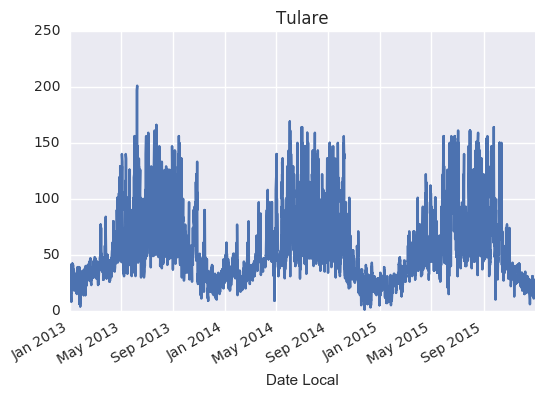

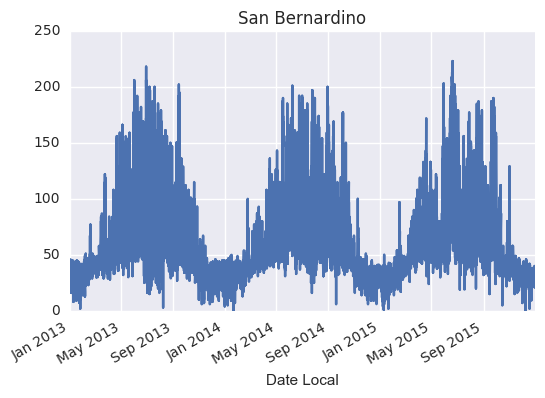

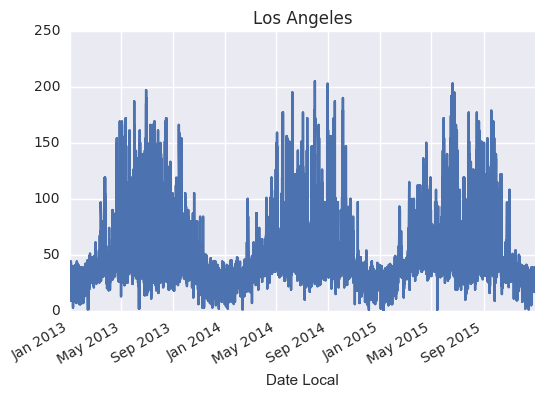

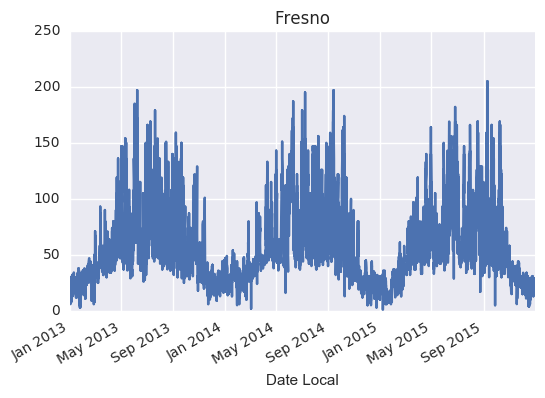

In [191]:
for i in CA_Counties:
    CA_3y_df[CA_3y_df['County Name']==i]['AQI'].plot().set_title(i)
    plt.show()


So this is looking like strong, seasonal, YoY trending. First, I'll difference the whole DF and see
how well I can get that to score, then moving more granularly, I'll test individual counties 
and see if it's enough. 

In [192]:
# for i in CA_Counties:
#     CA_3y_df[CA_3y_df['County Name']==i]['AQI']
CA_Counties

['Kern', 'Tulare', 'San Bernardino', 'Los Angeles', 'Fresno']

Let's isolate out these monthly high points by county so our lag offset will be accurate. 

In [193]:
Kern_df = CA_3y_df[CA_3y_df['County Name']=='Kern']['AQI'].resample('M', how='max')
Tulare_df = CA_3y_df[CA_3y_df['County Name']=='Tulare']['AQI'].resample('M', how='max')
San_Bernardino_df = CA_3y_df[CA_3y_df['County Name']=='San Bernardino']['AQI'].resample('M', how='max')
LA_df = CA_3y_df[CA_3y_df['County Name']=='Los Angeles']['AQI'].resample('M', how='max')
Fresno_df = CA_3y_df[CA_3y_df['County Name']=='Fresno']['AQI'].resample('M', how='max')

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  if __name__ == '__main__':
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  from ipykernel import kernelapp as app
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  app.launch_new_instance()
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


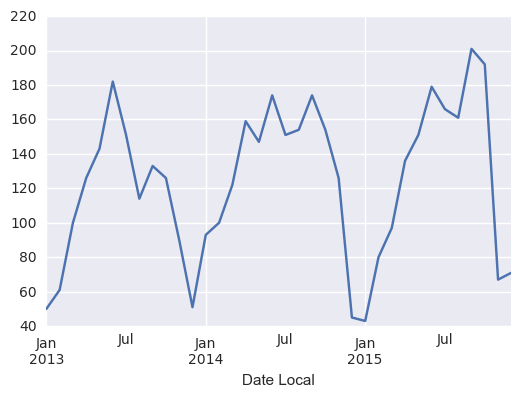

In [194]:
Kern_df.plot()

## Difference one county for a test case: 

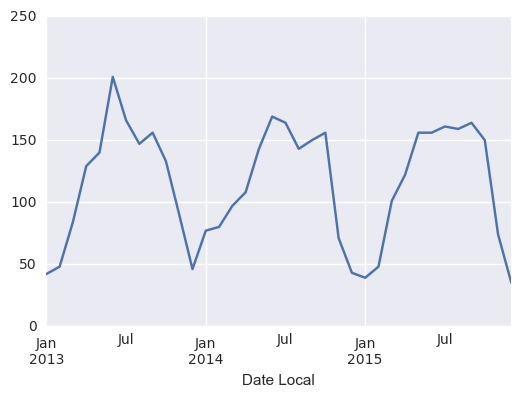

In [195]:
Tulare_df.plot()

In [196]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
#     rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [197]:
rolmean = pd.rolling_mean(Tulare_df, window=12)
rolmean

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


Date Local
2013-01-31           NaN
2013-02-28           NaN
2013-03-31           NaN
2013-04-30           NaN
2013-05-31           NaN
2013-06-30           NaN
2013-07-31           NaN
2013-08-31           NaN
2013-09-30           NaN
2013-10-31           NaN
2013-11-30           NaN
2013-12-31    115.166667
2014-01-31    118.083333
2014-02-28    120.750000
2014-03-31    121.833333
2014-04-30    120.083333
2014-05-31    120.333333
2014-06-30    117.666667
2014-07-31    117.500000
2014-08-31    117.166667
2014-09-30    116.666667
2014-10-31    118.583333
2014-11-30    117.000000
2014-12-31    116.750000
2015-01-31    113.583333
2015-02-28    110.916667
2015-03-31    111.250000
2015-04-30    112.416667
2015-05-31    113.500000
2015-06-30    112.416667
2015-07-31    112.166667
2015-08-31    113.500000
2015-09-30    114.666667
2015-10-31    114.166667
2015-11-30    114.416667
2015-12-31    113.750000
Freq: M, Name: AQI, dtype: float64

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


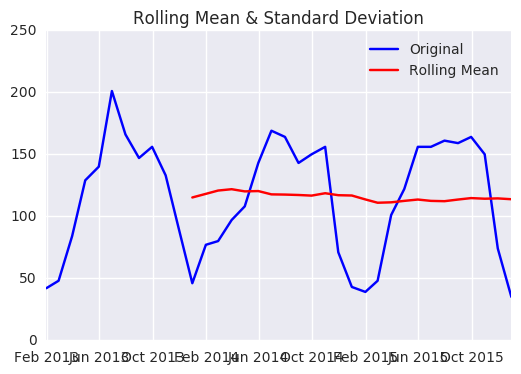

Results of Dickey-Fuller Test:
Test Statistic                 -1.385021
p-value                         0.589436
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64


In [198]:
test_stationarity(Tulare_df)

NOT Stationary

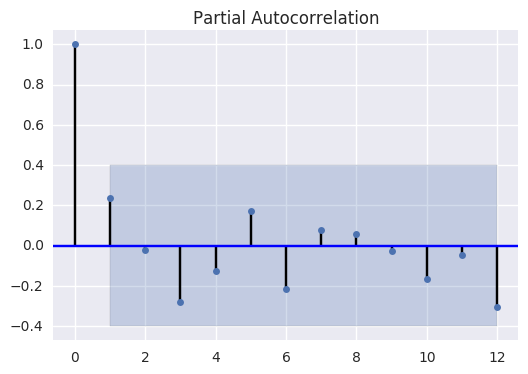

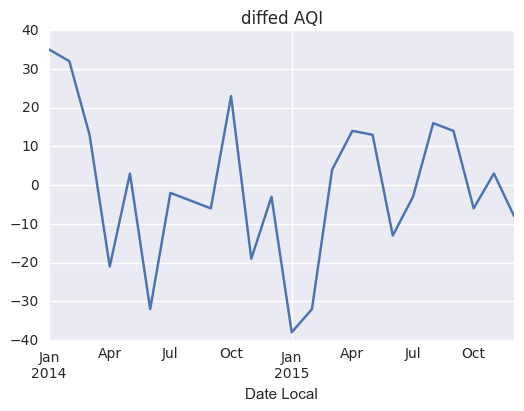

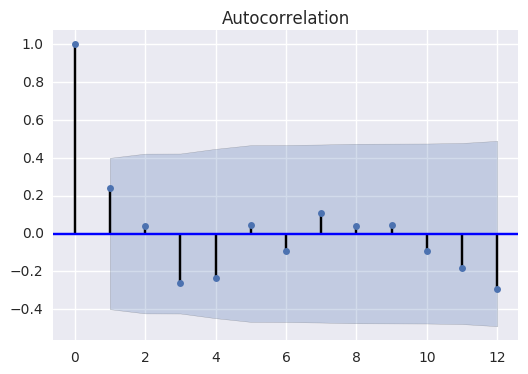

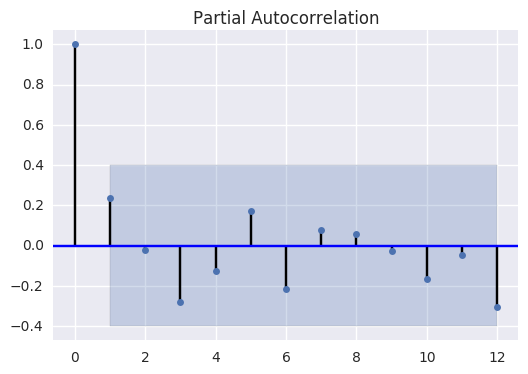

In [199]:
diff0 = Tulare_df.diff(periods=12)[12:]
diff0.plot(title='diffed AQI')
plot_acf(diff0, lags=12)
plot_pacf(diff0, lags=12)

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


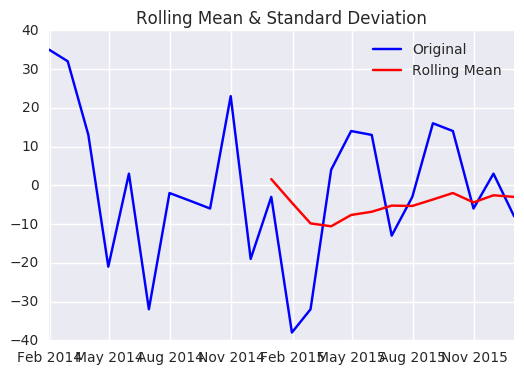

Results of Dickey-Fuller Test:
Test Statistic                 -3.911987
p-value                         0.001948
#Lags Used                      0.000000
Number of Observations Used    23.000000
Critical Value (5%)            -2.998500
Critical Value (1%)            -3.752928
Critical Value (10%)           -2.638967
dtype: float64


In [200]:
test_stationarity(diff0)

Rolling mean is a valid number to extrapolate from the diffed data (since the p value supports that this is in fact sufficiently diffed to move forward) for the value of the whole year. Esp since the factory data to compare is in year terms. 

In [201]:
# list_all_dfs = [Kern_df, Tulare_df , San_Bernardino_df , LA_df ,Fresno_df ]


In [202]:
print adfuller(Kern_df.diff(periods=12)[12:], autolag='AIC')[1]
print adfuller(San_Bernardino_df.diff(periods=12)[12:], autolag='AIC')[1]
print adfuller(Tulare_df.diff(periods=12)[12:], autolag='AIC')[1]
print adfuller(LA_df.diff(periods=12)[12:], autolag='AIC')[1]
print adfuller(Fresno_df.diff(periods=12)[12:], autolag='AIC')[1]

0.152636335655
4.452100791e-07
0.00194837831343
0.00430138825153
0.00889473569443


In [203]:
print adfuller(Kern_df.diff(periods=6)[6:], autolag='AIC')[1]
print adfuller(San_Bernardino_df.diff(periods=6)[6:], autolag='AIC')[1]
print adfuller(Tulare_df.diff(periods=6)[6:], autolag='AIC')[1]
print adfuller(LA_df.diff(periods=6)[6:], autolag='AIC')[1]
print adfuller(Fresno_df.diff(periods=6)[6:], autolag='AIC')[1]

1.98599629669e-11
1.81333906503e-05
9.53976919338e-18
0.373205940993
8.6824982497e-16


In [204]:
kern_diff1 = Kern_df.diff(periods=6)[6:]
# kern_diff2 = kern_diff1.diff()[1:]
# kern_diff2

# plot_acf(kern_diff1)
# plot_pacf(kern_diff1)

adfuller(kern_diff1, autolag='AIC')[1]

1.9859962966851766e-11

In [205]:


fres_dif = Fresno_df.diff()[2:]

Now that I know this makes for a pretty good baseline, I'll make a dictionary with the monthly sampled max ozone levels. Then, I'll diff everything to get them stationary based on my findings from the above worst offenders. 

In [206]:
## Make full dictionary
all_cty_dict = {}
to_fix = []
for cty in CA_County_full: 
    ##for each county, difference by 12 months, check score, if passable, add to dictionary 
    ##with cty name as key, dict and score as values
    og_df = CA_3y_df[CA_3y_df['County Name']== cty]['AQI'].resample('M', how='max')
    diffed_df = og_df.diff(periods=12)[12:]
    score = adfuller(diffed_df, autolag='AIC')[1]
    
    if score < 0.05: 
        all_cty_dict[cty] = [ og_df,pd.rolling_mean(og_df, window=12), diffed_df,score]
    else:
        ## If not passable, try differencing the original county values by a year, keep if good
        ## pass down if bad
        new_diff = og_df.diff(periods=6)[6:]
        other_score =  adfuller(new_diff, autolag='AIC')[1]
        
        if other_score <0.05: 
            all_cty_dict[cty] = [og_df, pd.rolling_mean(og_df, window=12), new_diff,other_score]
        else: 
            ## take a second diff from the 6 month diff
            ## keep if good, add to list if bad
            double_diff = new_diff.diff()[1:]
            dd_score =  adfuller(double_diff, autolag='AIC')[1]
            if dd_score <0.054:
                all_cty_dict[cty] = [ og_df, pd.rolling_mean(og_df, window=12),double_diff,dd_score]
            else:
                to_fix.append(cty)

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


In [207]:
to_fix

[]

In [208]:
# CA_3y_df['County Name']== cty]['AQI'].resample('M', how='max')

In [209]:
## Manual check of the problem children from function above

diffed_LA = CA_3y_df[CA_3y_df['County Name']== 'Kings']['AQI'].resample('M', how='max').diff(periods=6)[6:]
score = adfuller(diffed_LA, autolag='AIC')[1]
diffed_LA_2 = diffed_LA.diff()[1:]
score2 = adfuller(diffed_LA_2, autolag='AIC')[1]


score2

/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  app.launch_new_instance()


0.001187666463298458

In [210]:
##Dict structure - 
## key: county name 
## values: [0] undiffed monthly max data, [1] rolling mean of og_df, 
## [2] diffed monthly max data, [3] fuller stationarity score

In [211]:
all_cty_dict['Alameda'][1]


Date Local
2013-01-31          NaN
2013-02-28          NaN
2013-03-31          NaN
2013-04-30          NaN
2013-05-31          NaN
2013-06-30          NaN
2013-07-31          NaN
2013-08-31          NaN
2013-09-30          NaN
2013-10-31          NaN
2013-11-30          NaN
2013-12-31    70.250000
2014-01-31    70.583333
2014-02-28    70.583333
2014-03-31    70.000000
2014-04-30    73.750000
2014-05-31    75.250000
2014-06-30    74.083333
2014-07-31    75.583333
2014-08-31    74.500000
2014-09-30    74.833333
2014-10-31    79.666667
2014-11-30    79.833333
2014-12-31    79.750000
2015-01-31    79.166667
2015-02-28    79.000000
2015-03-31    79.250000
2015-04-30    76.583333
2015-05-31    73.583333
2015-06-30    75.083333
2015-07-31    73.833333
2015-08-31    80.416667
2015-09-30    84.583333
2015-10-31    80.333333
2015-11-30    79.916667
2015-12-31    79.916667
Freq: M, Name: AQI, dtype: float64

In [212]:
rolmean = pd.rolling_mean(Tulare_df, window=12)


/anaconda/envs/statsmodeldevenv/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


In [213]:
all_cty_dict['Alameda'][1]['2013-12'][0]

70.25

In [214]:
rmean_2013 = []
rmean_2014 = []
rmean_2015 = []
for i in CA_County_full:
    rmean_2013.append(all_cty_dict[i][1]['2013-12'].values)
    rmean_2014.append(all_cty_dict[i][1]['2014-12'].values)
    rmean_2015.append(all_cty_dict[i][1]['2015-12'].values)

In [215]:
print len(CA_County_full)
print len(rmean_2013)
print len(rmean_2014)
print len(rmean_2015)

49
49
49
49


In [216]:
bb = np.asarray([item for sublist in rmean_2013  for item in sublist ])
rmean_2013 = bb[np.logical_not(np.isnan(bb))]

cc = np.asarray([item for sublist in rmean_2014  for item in sublist ])
rmean_2014 = cc[np.logical_not(np.isnan(cc))]

dd = np.asarray([item for sublist in rmean_2015  for item in sublist ])
rmean_2015 = dd[np.logical_not(np.isnan(dd))]

In [217]:
#This is to test out the plot below.
xx = np.asarray([item for sublist in rmean_2015  for item in sublist ])
x = xx[np.logical_not(np.isnan(xx))]
np.std(x)

TypeError: 'numpy.float64' object is not iterable

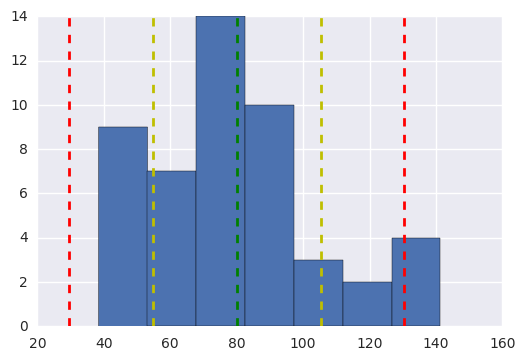

In [218]:
plt.axvline(x.mean(), color='g', linestyle='dashed', linewidth=2)
plt.axvline((x.mean() + x.std()), color='y', linestyle='dashed', linewidth=2)
plt.axvline((x.mean() - x.std()), color='y', linestyle='dashed', linewidth=2)
plt.axvline((x.mean() + 2*x.std()), color='r', linestyle='dashed', linewidth=2)
plt.axvline((x.mean() - 2*x.std()), color='r', linestyle='dashed', linewidth=2)

plt.hist(x, bins = 'auto')
plt.show()
# plt.hist(x)
        
    

In [219]:
tester = pd.DataFrame(Fresno_df)
tester = tester.reset_index()
tester

,Date Local,AQI
0,2013-01-31,38
1,2013-02-28,50
2,2013-03-31,93
3,2013-04-30,136
4,2013-05-31,154
5,2013-06-30,197
6,2013-07-31,179
7,2013-08-31,151
8,2013-09-30,159
9,2013-10-31,129


In [1]:
sns.tsplot(all_cty_dict['San Bernardino'][2])
sns.plt.title('San Bernardino Monthly AQI Trend')

NameError: name 'sns' is not defined

In [222]:

buoy_map = folium.Map(
    [46.3014, -123.7390],
    zoom_start=7,
    tiles='Stamen Terrain'
    )

# folium.RegularPolygonMarker(
#     [47.3489, -124.708],
#     fill_color='#43d9de',
#     radius=12,
#     popup=folium.Popup(max_width=450).add_child(
#         folium.Vega(vega_test), width=450, height=250)
#         ).add_to(buoy_map)

#http://python-visualization.github.io/folium/module/folium.html

# buoy_map.polygon_marker([46.216, -124.1280], fill_color='#43d9de', radius=12,
#                           popup=(vega_test, 'vega_test.json'))




## This almost works
# folium.RegularPolygonMarker(
#     [47.3489, -124.708],
#     fill_color='#43d9de',
#     radius=12,
#     popup=folium.Popup(max_width=450).add_child(
#       vega_test, 'vega_test.json')
#     ).add_to(buoy_map)



# folium.RegularPolygonMarker(
#     [44.639, -124.5339],
#     fill_color='#43d9de',
#     radius=12,
#     popup=folium.Popup(max_width=450).add_child(
#         folium.Vega(json.load(open('vis2.json')), width=450, height=250))
#     ).add_to(buoy_map)

# buoy_map = folium.Map(location=[46.3014, -123.7390], zoom_start=7,
# #                       tiles='Stamen Terrain')

# # buoy_map.polygon_marker([44.639, -124.5339], fill_color='#43d9de', radius=12,
#                         popup=(vis2, 'vis2.json'))
# 
# buoy_map.create_map(path='NOAA_buoys.html')

buoy_map

In [223]:
! wget http://catalog.civicdashboards.com/dataset/ce409ee1-5128-4b66-aa3e-957dbd4de8ba/resource/6f805645-0836-478d-b168-c1f72d53b4f3/download/5faf934922fd4748a843d55990297d9ftemp.geojson
    

--2016-11-22 23:48:14--  http://catalog.civicdashboards.com/dataset/ce409ee1-5128-4b66-aa3e-957dbd4de8ba/resource/6f805645-0836-478d-b168-c1f72d53b4f3/download/5faf934922fd4748a843d55990297d9ftemp.geojson
Resolving catalog.civicdashboards.com... 104.27.191.199, 104.27.190.199, 2400:cb00:2048:1::681b:bec7, ...
Connecting to catalog.civicdashboards.com|104.27.191.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332157 (324K) [application/json]
Saving to: ‘5faf934922fd4748a843d55990297d9ftemp.geojson’

5faf934922fd4748a84 100%[===================>] 324.37K  1.15MB/s    in 0.3s    

2016-11-22 23:48:15 (1.15 MB/s) - ‘5faf934922fd4748a843d55990297d9ftemp.geojson’ saved [332157/332157]



In [225]:
!ls mv 5faf934922fd4748a843d55990297d9ftemp.geojson CA_counties.geojson



ls: CA_counties.geojson: No such file or directory
ls: mv: No such file or directory
5faf934922fd4748a843d55990297d9ftemp.geojson


In [291]:
state_data = pd.DataFrame.from_dict(all_cty_dict).T.reset_index()
state_data['full'] = state_data['index'] + ' County, CA'
state_data = state_data.merge(geoid_df, how = 'left', left_on = 'index', right_on = 'County Name')
state_data = state_data.dropna()
state_data['geoid'] = state_data['geoid'].astype(str)
state_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61737 entries, 0 to 61736
Data columns (total 10 columns):
index          61737 non-null object
0              61737 non-null object
1              61737 non-null object
2              61737 non-null object
3              61737 non-null object
full           61737 non-null object
State Code     61737 non-null int64
County Code    61737 non-null int64
County Name    61737 non-null object
geoid          61737 non-null object
dtypes: int64(2), object(8)
memory usage: 5.2+ MB


In [296]:

county_geo = r'CA_county.geojson'
# state_unemployment = r'US_Unemployment_Oct2012.csv'

# state_data = pd.DataFrame.from_dict(all_cty_dict).T.reset_index()

#Let Folium determine the scale
map = folium.Map(location=[37.771186, -120.611102], zoom_start=6)
# map.choropleth(geo_path=county_geo, data=state_data,
#              columns=['geoid', 3],
#                 key_on='features.properties.geoid',
# #                highlight = True
#                fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2
# #              legend_name='Unemployment Rate (%)'
#             )

map.choropleth(geo_path='CA_county.geojson', line_color='grey',
                     line_weight=2)

map

In [227]:
county_geo

'CA_county.geojson'

In [ ]:
with open('2013_county_vars.pkl', 'w') as picklefile:
    pickle.dump(rmean_2013, picklefile)

In [ ]:
with open('2014_county_vars.pkl', 'w') as picklefile:
    pickle.dump(rmean_2014, picklefile)

In [ ]:
with open('2015_county_vars.pkl', 'w') as picklefile:
    pickle.dump(rmean_2015, picklefile)

In [ ]:
with open('all_ctys_dict.pkl', 'w') as picklefile:
    pickle.dump(all_cty_dict, picklefile)

In [ ]:
with open('county_name_list.pkl', 'w') as picklefile:
    pickle.dump(CA_County_full, picklefile)

In [ ]:
year_vals_dict = {}
for i in CA_County_full:
    year_vals_dict[i] = [all_cty_dict[i][1]['2013-12'][0], all_cty_dict[i][1]['2014-12'][0], all_cty_dict[i][1]['2015-12'][0]]
   

In [ ]:
with open('county_year_vals.pkl', 'w') as picklefile:
    pickle.dump(year_vals_dict, picklefile)



In [ ]:
CA_County_full

In [ ]:
## OLD STUFF

In [ ]:
diff0 = CA_3y_df['AQI'].diff(periods=2)[2:]
diff0.plot(title='diffed AQI')
plot_acf(diff0, lags=90)
plot_pacf(diff0, lags=90)

In [ ]:
diff0.plot(title='Diffed CA')
plot_acf(diff0, lags = 365)
plot_pacf(diff0, lags = 365)

In [ ]:
# full_14['full'] = full_14['date_gmt'].astype(str).apply(lambda x: x.split('-'))
# full_14['year'] = full_14['full'].apply( lambda x: x[0] ).astype(int)
# full_14['month'] = full_14['full'].apply( lambda x: x[1] ).astype(int)
# full_14['day'] = full_14['full'].apply( lambda x: x[2] ).astype(int)
# full_14['hour'] = full_14['24_hour_gmt'].apply(lambda x: x.split(':')[0]).astype(int)

In [ ]:
# full_14 = full_14.set_index(pd.to_datetime(full_14[['year','month','day','hour']]))

In [ ]:
#pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

In [ ]:
full_14[['date_local', u'24_hour_local', u'date_gmt',
       u'24_hour_gmt', u'year_gmt', u'day_in_year_gmt', u'sample_measurement',
       u'units_of_measure', u'sample_duration', u'sample_frequency']]

In [ ]:
full_14['date_gmt'] = pd.to_datetime(full_14['date_gmt'])



In [ ]:
full_14['24_hour_gmt'].astype(int)

In [ ]:
full_14['date_gmt'] + full_14['24_hour_gmt']

In [ ]:
full_14[['date_gmt','24_hour_gmt']]